# Import Packages

In [48]:
"""
Main File for QRT - Electricity Price - 2023 Project
"""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Data Preprocessing

In [49]:
# Importing Data From Files
curr_dir = '/Users/talhajamal/Desktop/Code/Python_Projects/QRT - 2023 - Electricity Price/'

x_train = pd.read_csv(f"{curr_dir}data/X_train_NHkHMNU.csv").set_index('ID').sort_index()
y_train = pd.read_csv(f"{curr_dir}data/y_train_ZAN5mwg.csv").set_index('ID').sort_index()
x_test = pd.read_csv(f"{curr_dir}data/X_test_final.csv").set_index('ID')

# Combined Training and Testing Data
full_data = pd.concat([x_train, x_test], axis=0).sort_index()
de_full_data = full_data[full_data['COUNTRY'] == 'DE']
fr_full_data = full_data[full_data['COUNTRY'] == 'FR']

# Separating data for each country
de_x_train = x_train[x_train['COUNTRY'] == 'DE']
de_y_train = y_train[y_train.index.isin(de_x_train.index)]
fr_x_train = x_train[x_train['COUNTRY'] == 'FR']
fr_y_train = y_train[y_train.index.isin(fr_x_train.index)]

# Useful Functions

In [60]:
def plot_ts(ts: pd.Series, title: str = None, figsize=(13,5)) -> None:
    """plots a given timeseries and displays an optional title"""
    plt.figure(figsize=figsize)
    ax = plt.subplot(111)
    plt.plot(ts)
    plt.title(title or '', fontsize=10)
    plt.grid(alpha=0.5, linestyle='dashed')
    plt.show()

# Split Data

In [61]:
x_train_cols = x_train.columns
x_train_cols

Index(['DAY_ID', 'COUNTRY', 'DE_CONSUMPTION', 'FR_CONSUMPTION',
       'DE_FR_EXCHANGE', 'FR_DE_EXCHANGE', 'DE_NET_EXPORT', 'FR_NET_EXPORT',
       'DE_NET_IMPORT', 'FR_NET_IMPORT', 'DE_GAS', 'FR_GAS', 'DE_COAL',
       'FR_COAL', 'DE_HYDRO', 'FR_HYDRO', 'DE_NUCLEAR', 'FR_NUCLEAR',
       'DE_SOLAR', 'FR_SOLAR', 'DE_WINDPOW', 'FR_WINDPOW', 'DE_LIGNITE',
       'DE_RESIDUAL_LOAD', 'FR_RESIDUAL_LOAD', 'DE_RAIN', 'FR_RAIN', 'DE_WIND',
       'FR_WIND', 'DE_TEMP', 'FR_TEMP', 'GAS_RET', 'COAL_RET', 'CARBON_RET'],
      dtype='object')

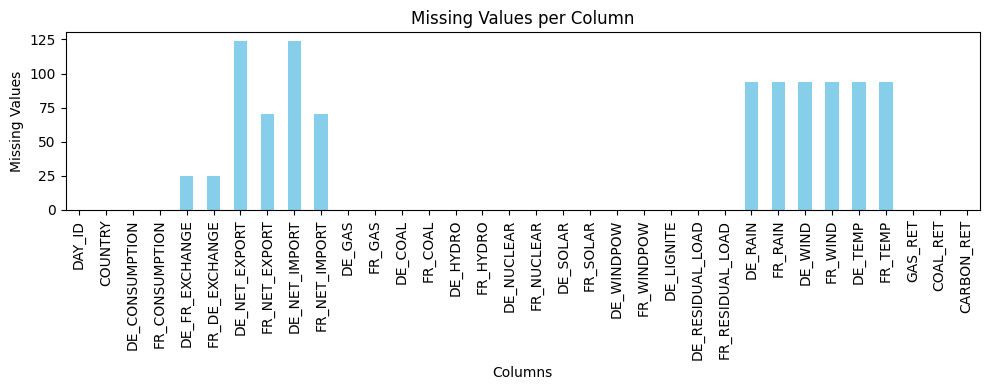

In [62]:
missing_values = x_train.isna().sum()
missing_values.plot(kind='bar', figsize=(10, 4), color='skyblue')
plt.title('Missing Values per Column')
plt.xlabel('Columns')
plt.ylabel('Missing Values')
plt.xticks(rotation=90)  # Rotate the x labels to show them vertically
plt.tight_layout()  # Adjust layout to make room for the x labels
plt.show()

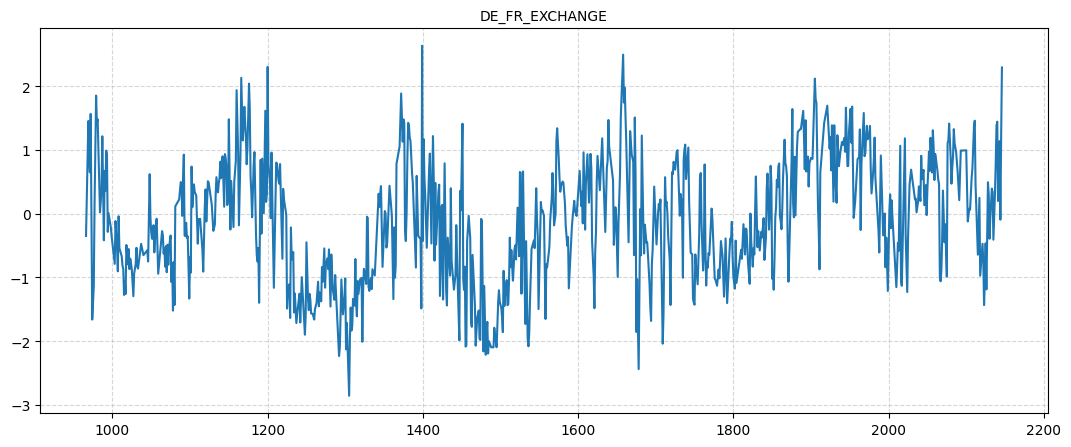

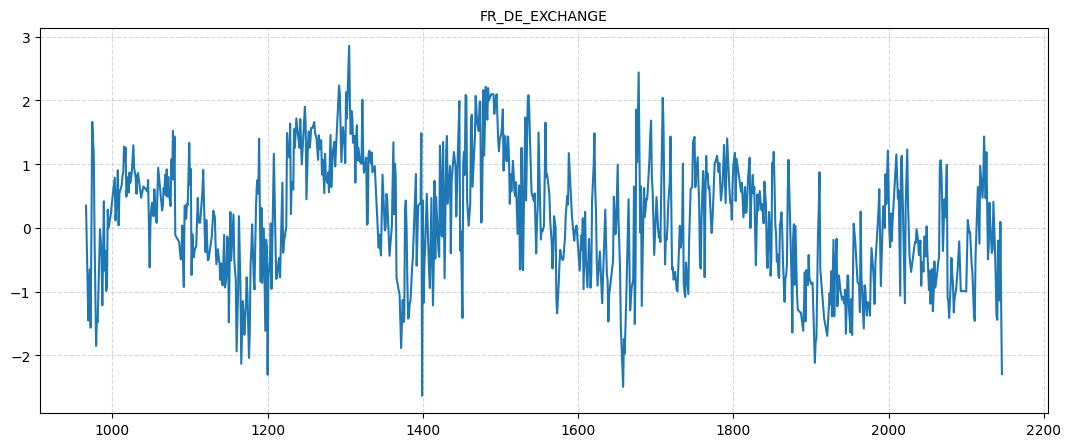

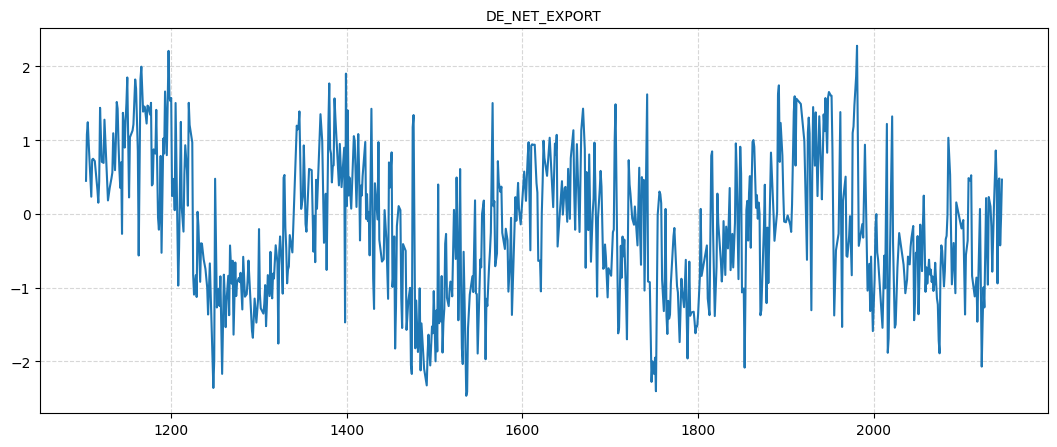

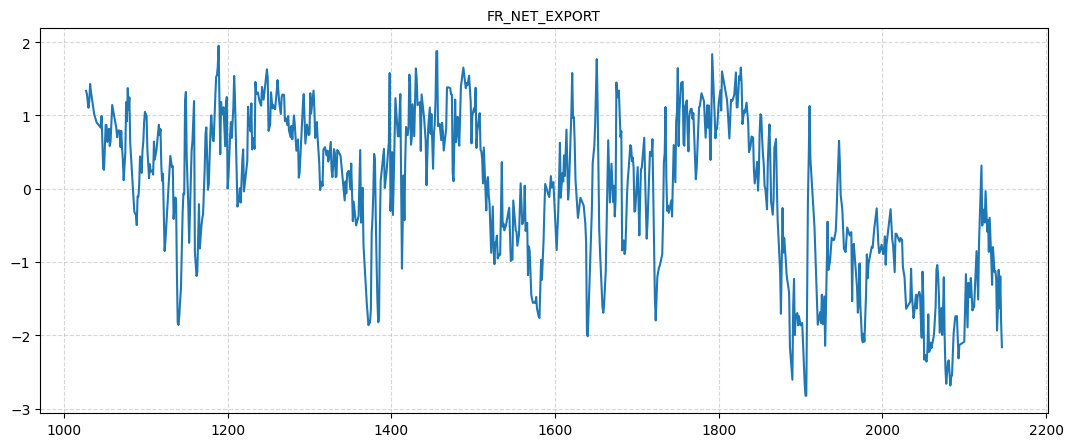

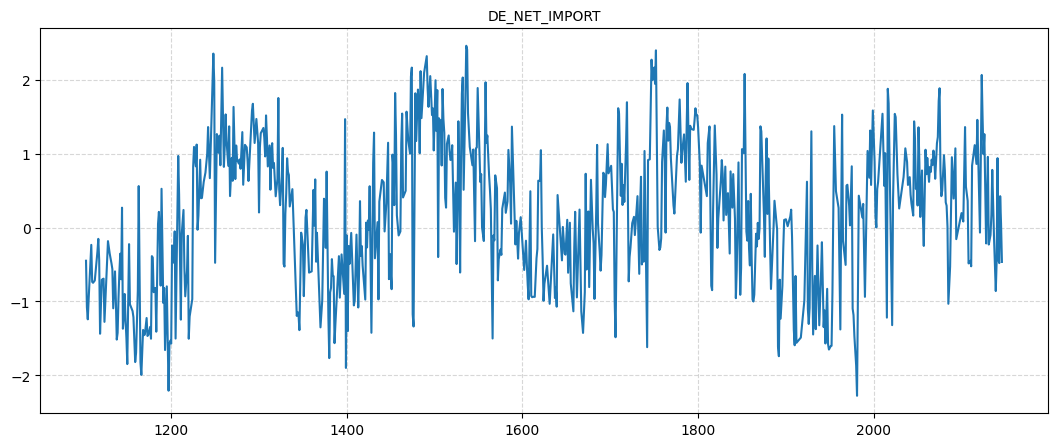

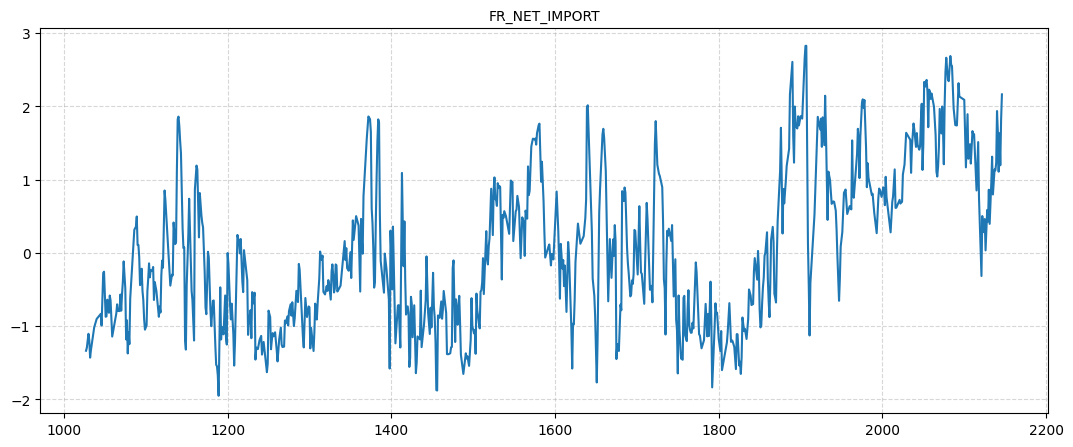

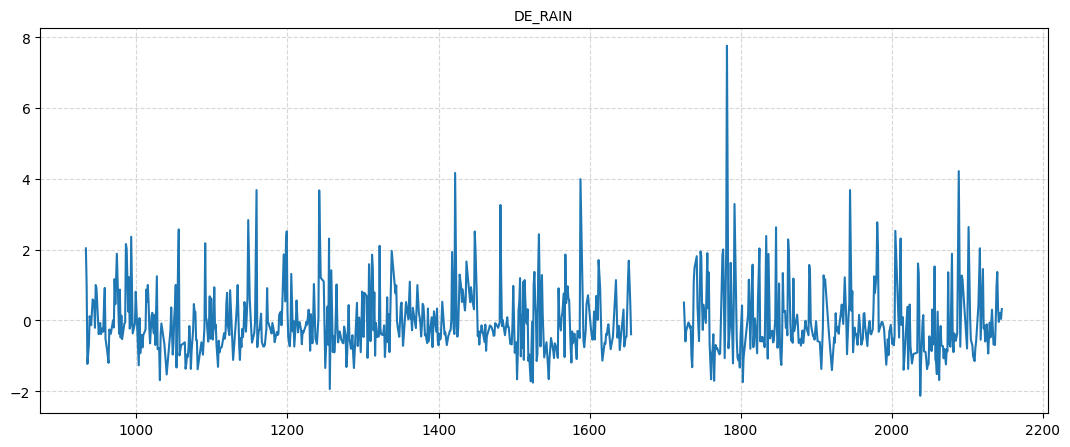

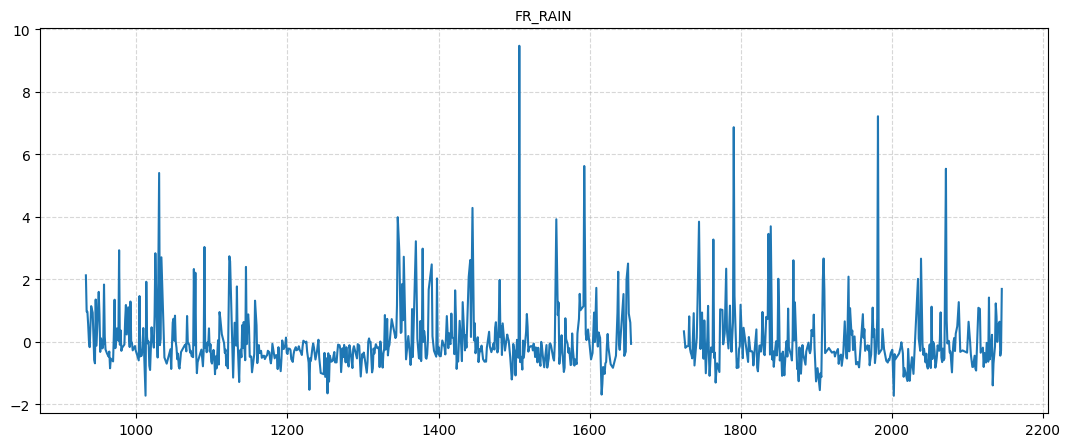

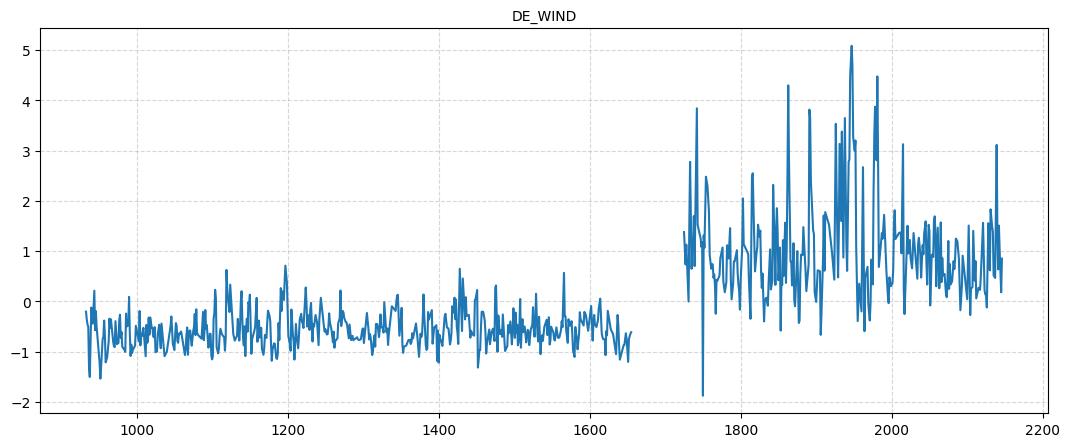

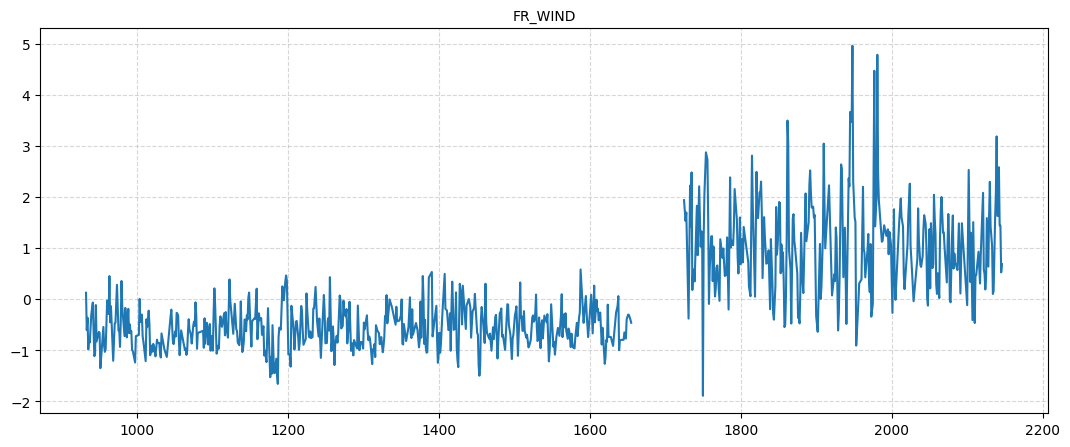

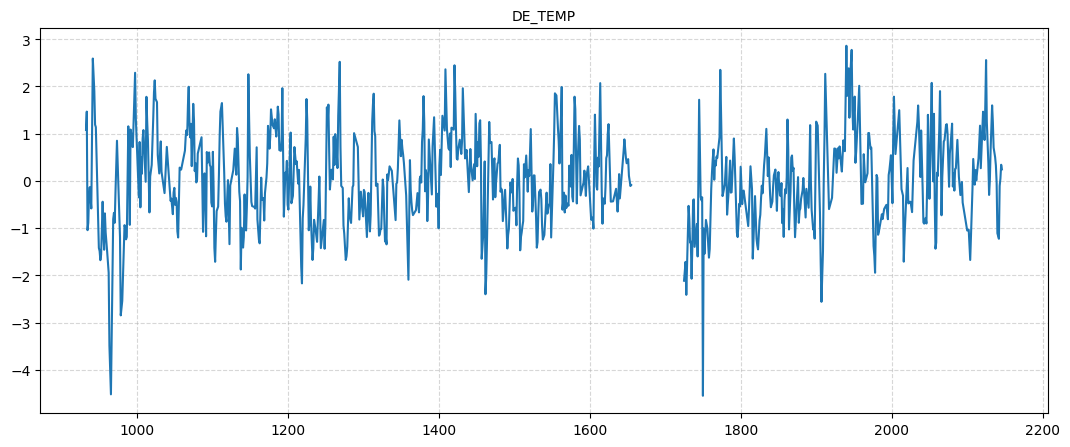

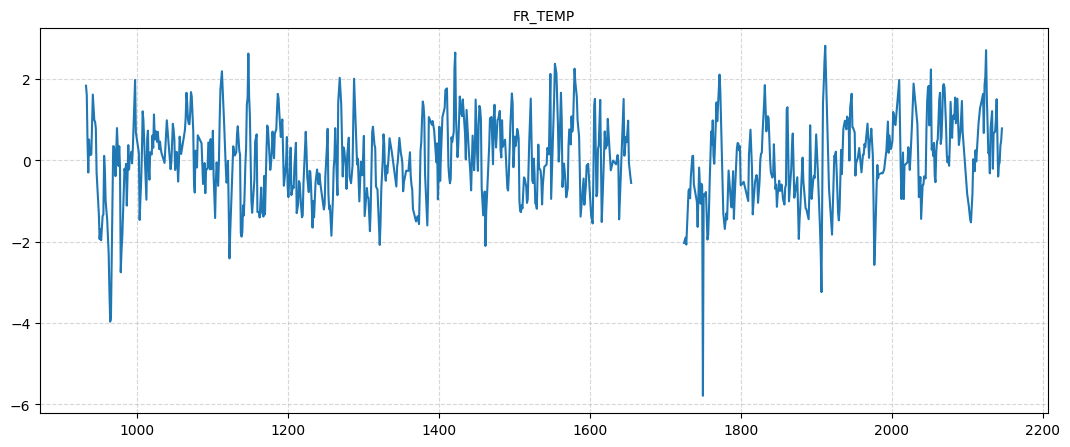

In [68]:
missing_columns = missing_values[missing_values > 0]
for col in missing_columns.index:
    plot_ts(fr_x_train[col], col)

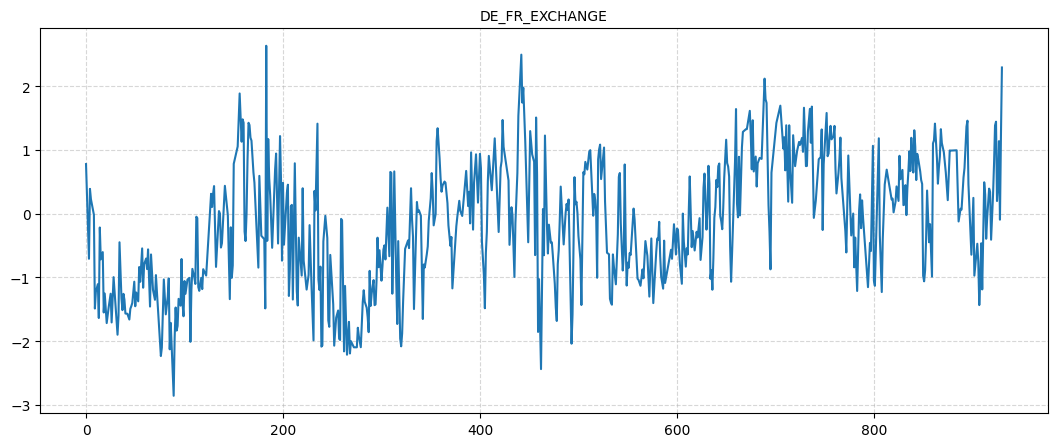

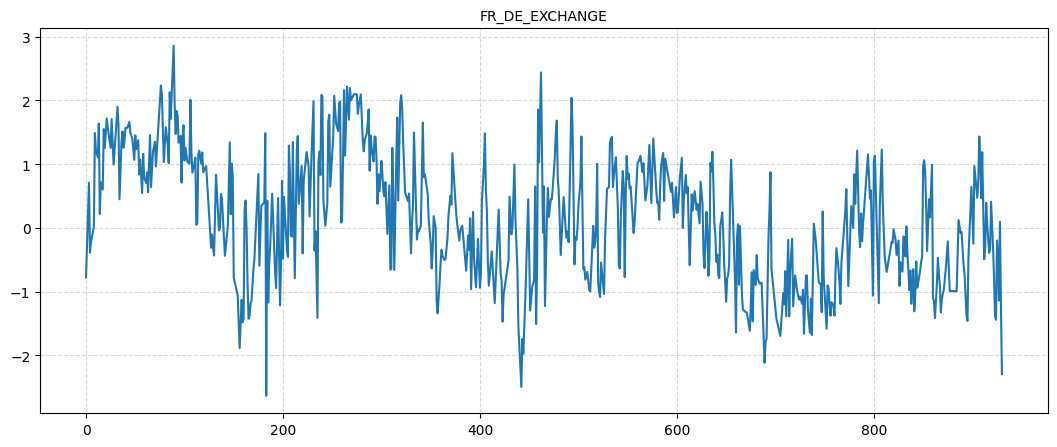

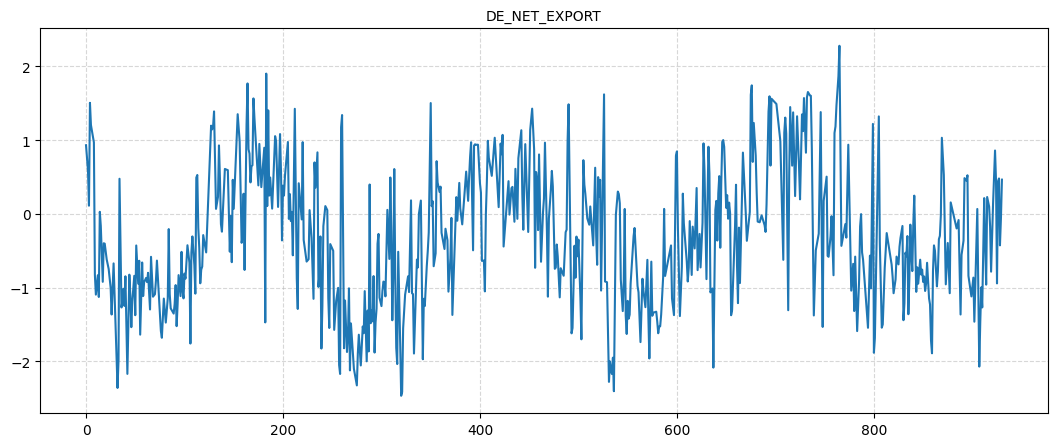

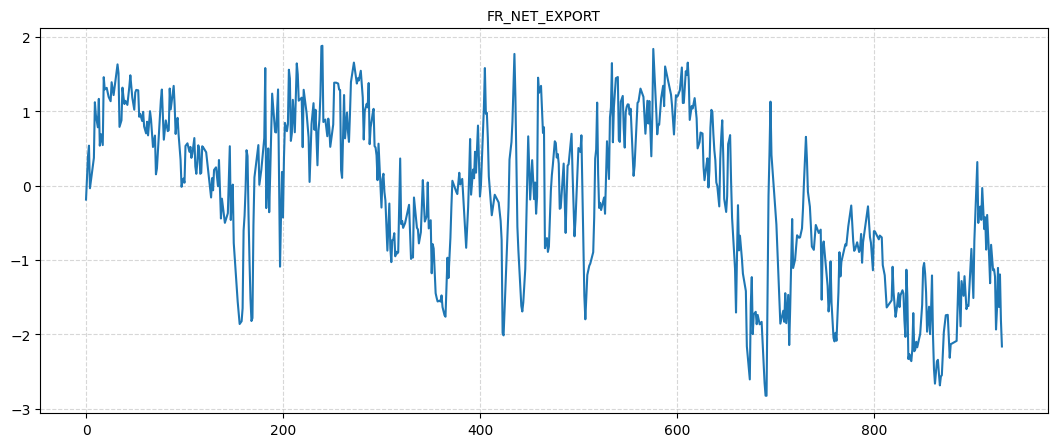

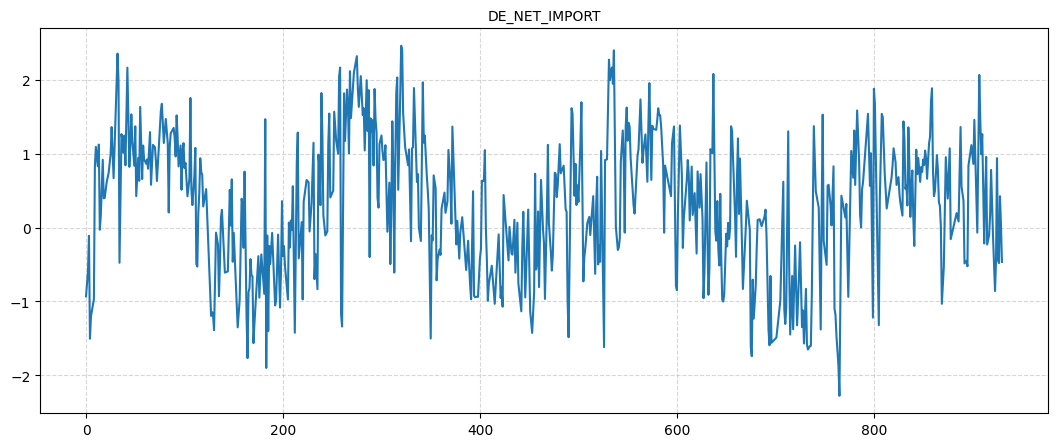

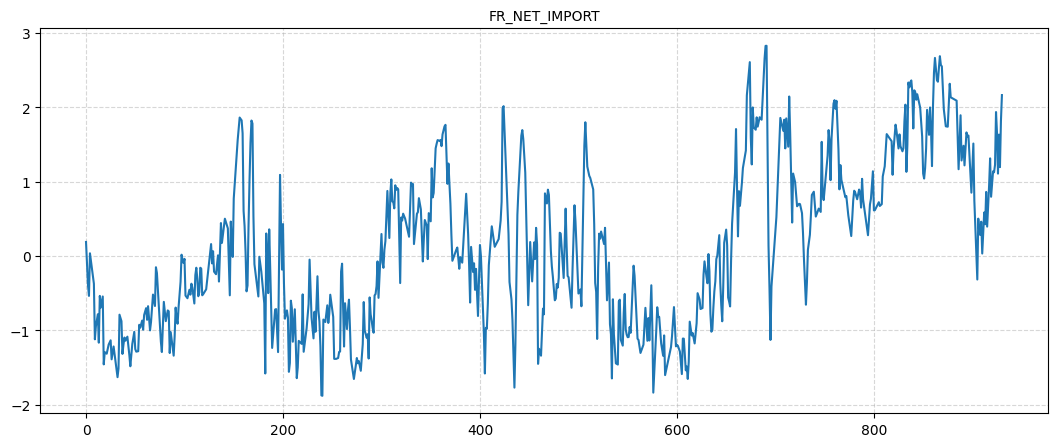

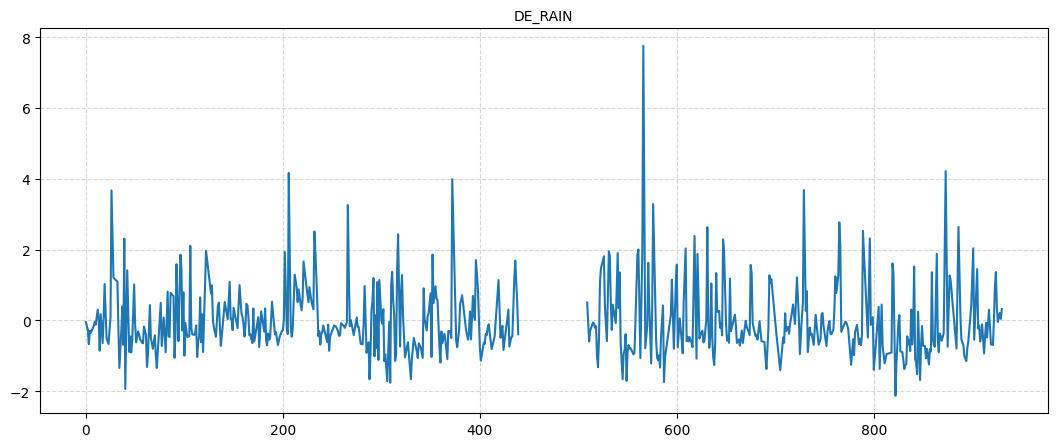

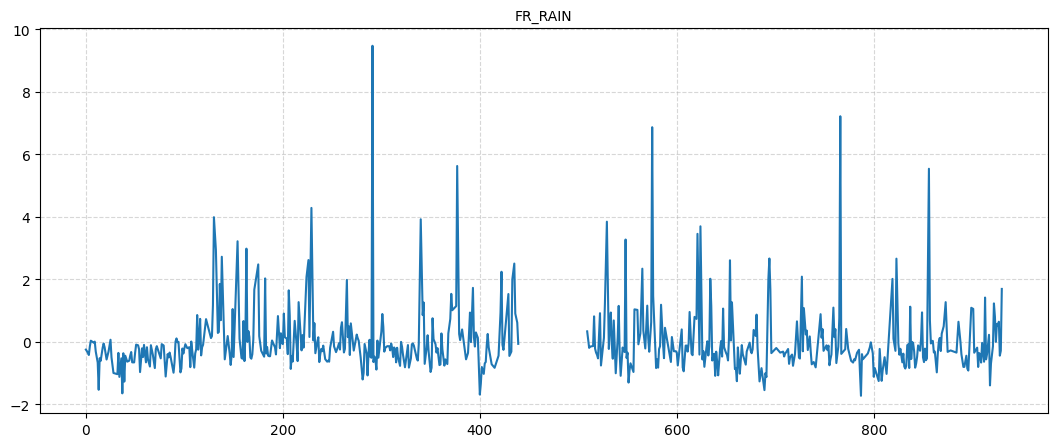

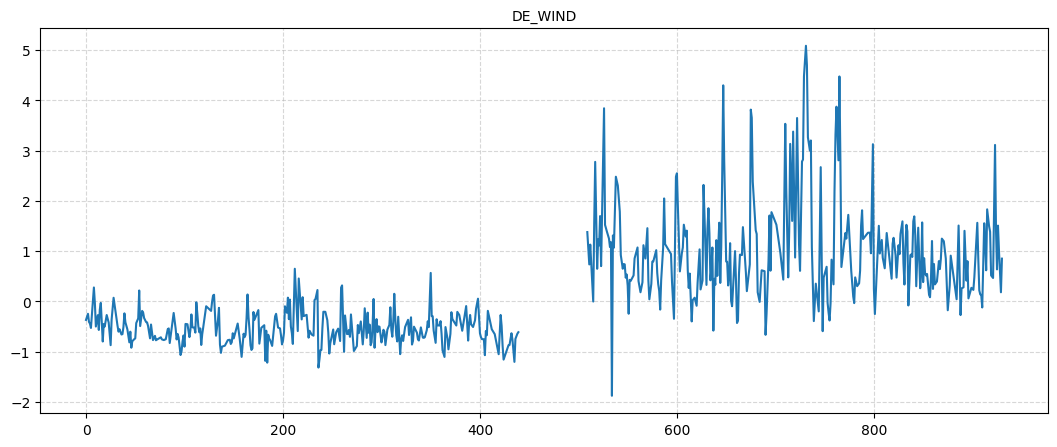

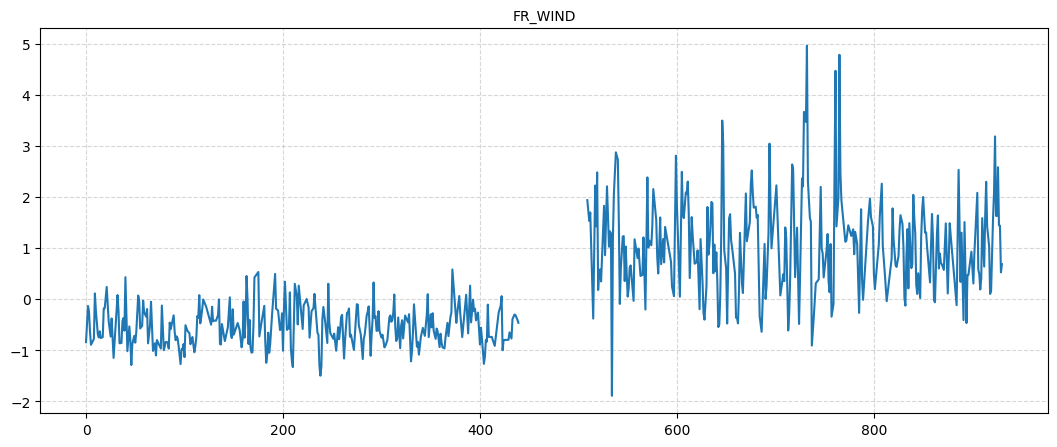

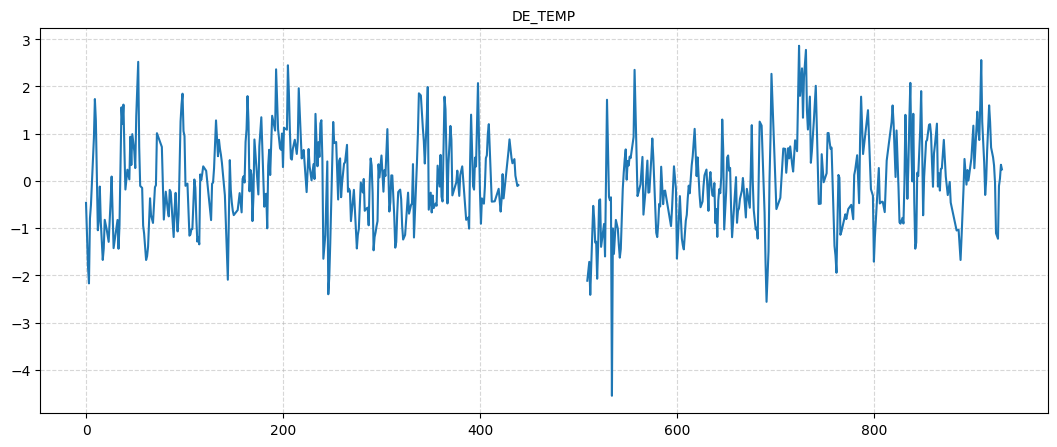

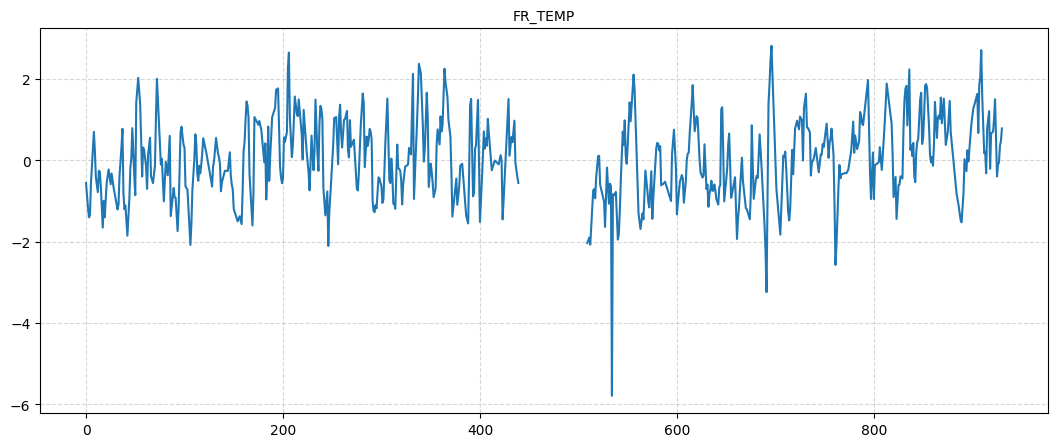

In [69]:
for col in missing_columns.index:
    plot_ts(de_x_train[col], col)